# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [1]:
!pip install stable-baselines3 gym==0.22.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [2]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right.

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [3]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


observation dim (4,) number of actions 2


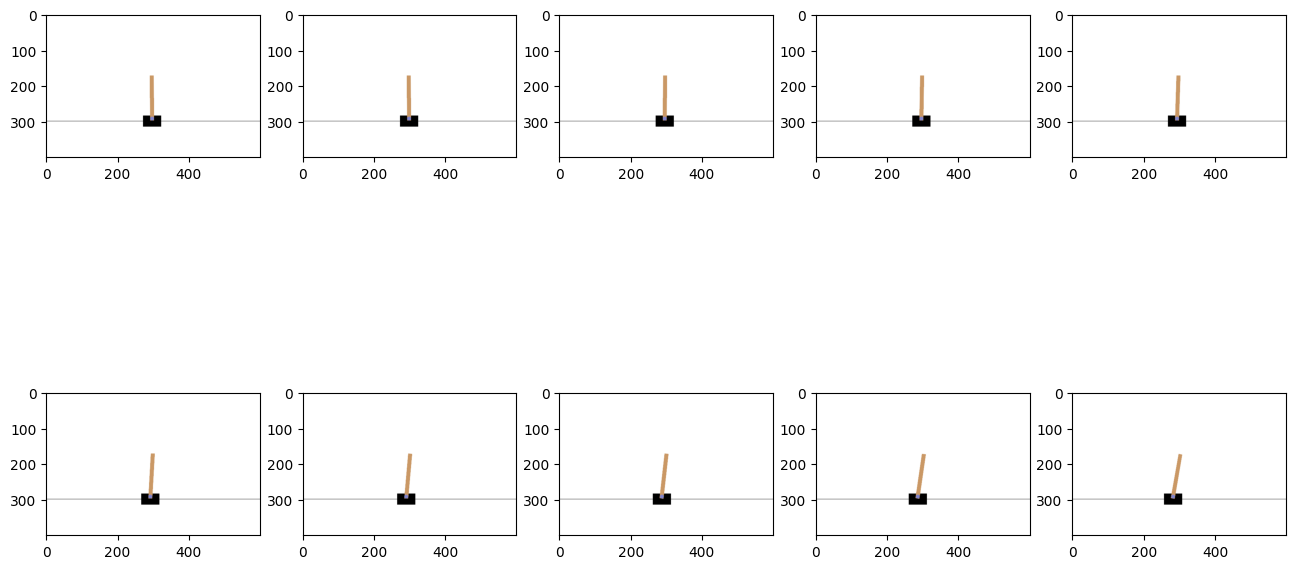

In [4]:
env = gym.make(ENV_NAME)
obs = env.reset()


n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [5]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [6]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [7]:
# run sessions

# import gym.wrappers
# import sys
# from pathlib import Path
# from base64 import b64encode
# from IPython.display import HTML

# n_games = 1 # how many games to record

# with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
#     env_monitor.reset()
#     sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


In [8]:
# show video

# video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
# video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

# if 'google.colab' in sys.modules:
#     # https://stackoverflow.com/a/57378660/1214547
#     with video_path.open('rb') as fp:
#         mp4 = fp.read()
#     data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
# else:
#     data_url = str(video_path)

# HTML("""
# <video width="640" height="480" controls>
#   <source src="{}" type="video/mp4">
# </video>
# """.format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [10]:
# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim[0], 32)
        self.fc2 = nn.Linear(32, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [19]:
# DQN Agent
class DQNAgent:
    def __init__(self, obs_dim, n_actions, gamma=0.99, eps_start=1.0, eps_end=0.01, eps_decay=0.995, buffer_size=10000):
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.buffer = deque(maxlen=buffer_size)
        self.q_net = QNetwork(obs_dim, n_actions)
        self.target_q_net = QNetwork(obs_dim, n_actions)
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters())

    def get_action(self, state):
        if random.random() < self.epsilon:
            action = random.randint(0, self.n_actions - 1)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.q_net(state_tensor)
            action = torch.argmax(q_values).item()
        return action

    def update_buffer(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def update_q_net(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.q_net(states).gather(1, actions)
        with torch.no_grad():
          next_q_values = self.target_q_net(next_states).max(1)[0].detach()
          expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.eps_end, self.epsilon * self.eps_decay)

    def update_target_q_net(self):
        self.target_q_net.load_state_dict(self.q_net.state_dict())


In [20]:
# Training loop
def train(env, agent, num_episodes, batch_size=64, target_update_freq=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_buffer(state, action, reward, next_state, done)
            agent.update_q_net(batch_size)
            state = next_state
            episode_reward += reward
        rewards.append(episode_reward)
        if episode % target_update_freq == 0:
            agent.update_target_q_net()
        print(f"Episode {episode+1}, Reward: {episode_reward}")
    return rewards

In [21]:
# Example usage
env = make_env()
obs_dim = env.observation_space.shape
n_actions = env.action_space.n
agent = DQNAgent(obs_dim, n_actions)
rewards = train(env, agent, num_episodes=200)

Episode 1, Reward: 32.0
Episode 2, Reward: 29.0
Episode 3, Reward: 12.0
Episode 4, Reward: 12.0
Episode 5, Reward: 12.0
Episode 6, Reward: 10.0
Episode 7, Reward: 11.0
Episode 8, Reward: 16.0
Episode 9, Reward: 26.0
Episode 10, Reward: 10.0
Episode 11, Reward: 11.0
Episode 12, Reward: 11.0
Episode 13, Reward: 11.0
Episode 14, Reward: 10.0
Episode 15, Reward: 10.0
Episode 16, Reward: 9.0
Episode 17, Reward: 10.0
Episode 18, Reward: 8.0
Episode 19, Reward: 11.0
Episode 20, Reward: 9.0
Episode 21, Reward: 9.0
Episode 22, Reward: 16.0
Episode 23, Reward: 10.0
Episode 24, Reward: 9.0
Episode 25, Reward: 9.0
Episode 26, Reward: 10.0
Episode 27, Reward: 11.0
Episode 28, Reward: 12.0
Episode 29, Reward: 12.0
Episode 30, Reward: 11.0
Episode 31, Reward: 11.0
Episode 32, Reward: 11.0
Episode 33, Reward: 11.0
Episode 34, Reward: 10.0
Episode 35, Reward: 9.0
Episode 36, Reward: 13.0
Episode 37, Reward: 10.0
Episode 38, Reward: 12.0
Episode 39, Reward: 10.0
Episode 40, Reward: 11.0
Episode 41, Rewa

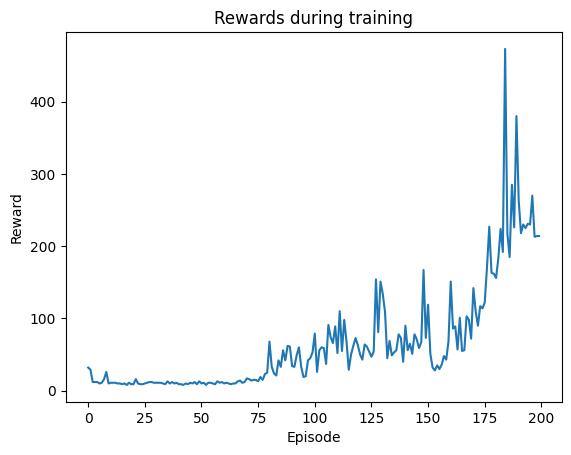

In [22]:
# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.title("Rewards during training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [23]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    state = env_monitor.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        state, _, done, _ = env_monitor.step(action)


# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))